<a href="https://colab.research.google.com/github/Bhavin52/Deep_learning/blob/main/satellite_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import os
import random
import cv2
import matplotlib.pyplot as plt

In [3]:
DATADIR= '/content/drive/MyDrive/satellite image classification/data'
CATEGORIES = os.listdir(DATADIR)
print(CATEGORIES)

['cloudy', 'water', 'desert', 'green_area']


In [4]:
def load_images(DATADIR, CATEGORIES):
    images = []
    labels = []
    
    nb_images_each_type = []
    for category in CATEGORIES:
        beginning = len(images)
        class_number = CATEGORIES.index(category)
        path = os.path.join(DATADIR, category)
        for img in os.listdir(path):
            img = cv2.imread(os.path.join(path, img))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256,256))
            images.append(img)
            labels.append(class_number)
            
            # Adding rotated image
            param = random.choice([-180, -90, 90])
            if param == -180:
                img_rotated = cv2.rotate(img, cv2.ROTATE_180)
            elif param == -90:
                img_rotated = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
            elif param == 90:
                img_rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
            images.append(img_rotated)
            labels.append(class_number)
            
            # Adding rotated and cropped image
            img_cropped = img[32:224, 32:224]
            param = random.choice([-180, -90, 90])
            if param == -180:
                img_cropped = cv2.rotate(img_cropped, cv2.ROTATE_180)
            elif param == -90:
                img_cropped = cv2.rotate(img_cropped, cv2.ROTATE_90_COUNTERCLOCKWISE)
            elif param == 90:
                img_cropped = cv2.rotate(img_cropped, cv2.ROTATE_90_CLOCKWISE)
            img_cropped = cv2.resize(img_cropped, (256,256))
            images.append(img_cropped)
            labels.append(class_number)
              
        end = len(images)
        nb_images_each_type.append(end-beginning)
    images = np.array(images)
    labels = np.array(labels)
    
    # Displaying dataset info
    print(f'images: {len(images)}; labels: {len(labels)}')
    print('image size:', images[0].shape)
    print('-'*25)
    print('number of images of each label:')
    for i in range(len(CATEGORIES)):
        print(f'{CATEGORIES[i]}: {nb_images_each_type[i]}')
    print('-'*25)
    from sys import getsizeof
    print(f'size of dataset: {getsizeof(images)/1024/1024} MB; {getsizeof(images)/1024/1024/1024} GB')
    plt.imshow(images[random.randint(0, len(images))])
    
    return images, labels

images: 16893; labels: 16893
image size: (256, 256, 3)
-------------------------
number of images of each label:
cloudy: 4500
water: 4500
desert: 3393
green_area: 4500
-------------------------
size of dataset: 3167.437644958496 MB; 3.0932008251547813 GB


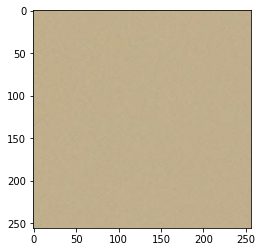

In [5]:
images, labels = load_images(DATADIR, CATEGORIES)

Splitting data into training and test data and making labels categorical

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [7]:
labels = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=.85, random_state=1)
images, labels = 0, 0

Importing tools needed to create CNN

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

Building CNN



In [9]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(8,8), strides=(1,1), padding='same', activation='relu', input_shape=(256,256,3)))
model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))
model.add(Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(3,3)))
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(3,3)))

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=len(CATEGORIES), activation='softmax'))

model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      3088      
                                                                 
 dropout (Dropout)           (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 16)        6416      
                                                                 
 dropout_1 (Dropout)         (None, 85, 85, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                    

Training model

In [ ]:
model.fit(X_train[:-300], y_train[:-300], epochs=15, batch_size=64, validation_data=(X_train[-300:], y_train[-300:]))

Epoch 1/15
220/220 [==============================] - 1362s 6s/step - loss: 1.4897 - accuracy: 0.7490 - val_loss: 0.4426 - val_accuracy: 0.8333
Epoch 2/15
 69/220 [========>.....................] - ETA: 15:30 - loss: 0.4031 - accuracy: 0.8347

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
predictions = model.predict(X_test)
print(f'results len: {len(predictions)}')
incorr_imgs = []
incorr_labels = []
for i in range(len(X_test)):
    if np.argmax(y_test[i]) != np.argmax(predictions[i]):
        incorr_imgs.append(X_test[i])
        incorr_labels.append([CATEGORIES[np.argmax(y_test[i])], CATEGORIES[np.argmax(predictions[i])]])
print(f'incorr_img len: {len(incorr_imgs)}')